In [2]:
import os
import sys

home=os.path.expanduser("~")
os.environ["SPARK_HOME"]=os.path.join(home, 'spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [3]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).getOrCreate()

# 문제 1

In [3]:
sing = [
"When I find myself in times of trouble",
"Mother Mary comes to me",
"Speaking words of wisdom, let it be",
"And in my hour of darkness",
"She is standing right in front of me",
"Speaking words of wisdom, let it be",
"Let it be",
"Let it be",
"Let it be",
"Let it be",
"Whisper words of wisdom, let it be"]

myRdd=spark.sparkContext.parallelize(sing)

for line in myRdd.take(5):
    print line

print '\n'
    
stopwords = ['IS','AM','ARE','THE','FOR','A', 'AN', 'AT', 'OF']

wordCount = myRdd\
    .flatMap(lambda x : x.split())\
    .filter(lambda x : x.upper() not in stopwords)\
    .map(lambda x : (x.upper(), 1))\
    .reduceByKey(lambda x, y : x + y)\
    .map(lambda x : (x[1], x[0]))\
    .sortByKey(False)\
    .collect()

for k in wordCount:
    print k

When I find myself in times of trouble
Mother Mary comes to me
Speaking words of wisdom, let it be
And in my hour of darkness
She is standing right in front of me


(7, 'BE')
(7, 'LET')
(7, 'IT')
(3, 'WISDOM,')
(3, 'WORDS')
(3, 'IN')
(2, 'ME')
(2, 'SPEAKING')
(1, 'AND')
(1, 'STANDING')
(1, 'I')
(1, 'FRONT')
(1, 'TO')
(1, 'WHISPER')
(1, 'MYSELF')
(1, 'TROUBLE')
(1, 'RIGHT')
(1, 'WHEN')
(1, 'MY')
(1, 'SHE')
(1, 'DARKNESS')
(1, 'FIND')
(1, 'MARY')
(1, 'HOUR')
(1, 'COMES')
(1, 'MOTHER')
(1, 'TIMES')


# 문제 2

In [4]:
marks=[
    "'201411111', 'lim js', '휴먼', 58, 165",
    "'201811111', 'kim js', '휴먼', 79, 175",
    "'201211111', 'lee js', '휴먼', 65, 180",
    "'201511111', 'choi js', '컴과', 66, 163",
    "'201911111', 'yoon js', '컴과', 65, 158",
    "'201311111', 'park js', '경영', 100, 160",    
]

marksRdd=spark.sparkContext.parallelize(marks)
heightInch=marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[1],float(x[3]) * 2.20462262))\
    .collect()
for i in heightInch:
    print i[0],i[1]
    
print '\n'    
    
marksByDep=marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x: (x[2],float(x[3])))\
    .reduceByKey(lambda x,y:x+y)\
    .collect()
for i in marksByDep:
    print i[0],i[1]   

print '\n'  


BMIList=marksRdd\
    .map(lambda x:x.split(','))\
    .map(lambda x:(x[1],float(x[3]), float(x[4])))\
    .collect()

for line in BMIList:
    bmiValue = line[1] / ((line[2] / 100) * (line[2] / 100))
    if bmiValue <= 18.5:
        print line[0], '저체중'
    elif bmiValue < 23:
        print line[0], '정상'
    elif bmiValue < 25:
        print line[0], '과체중'
    elif bmiValue < 30:
        print line[0], '비만'
    else:
        print line[0], '고도비만'

 'lim js' 127.86811196
 'kim js' 174.16518698
 'lee js' 143.3004703
 'choi js' 145.50509292
 'yoon js' 143.3004703
 'park js' 220.462262


 '경영' 100.0
 '휴먼' 202.0
 '컴과' 131.0


 'lim js' 정상
 'kim js' 비만
 'lee js' 정상
 'choi js' 과체중
 'yoon js' 비만
 'park js' 고도비만


# 문제 3

2018-01-01 00:00:00 4950
2018-01-02 00:00:00 7136
2018-01-03 00:00:00 7156
2018-01-04 00:00:00 7102
2018-01-05 00:00:00 7705


+----+------------------+
|year|        avg(count)|
+----+------------------+
|2018| 27739.38082191781|
|2019|20799.277777777777|
+----+------------------+

+-----+------------------+
|month|        avg(count)|
+-----+------------------+
|   12|16155.548387096775|
|    1|10644.193548387097|
|    6|40237.433333333334|
|    3|22056.129032258064|
|    5|31148.677419354837|
|    9|48266.433333333334|
|    4|           22929.5|
|    8|33467.903225806454|
|    7|35484.354838709674|
|   10| 45826.48387096774|
|   11|32051.066666666666|
|    2|11433.642857142857|
+-----+------------------+



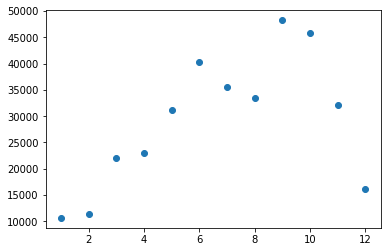

In [9]:
bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/seoulBicycleDailyCount_2018_201903.csv')

# 컬럼 변경
cleanBicycle=bicycle\
    .withColumnRenamed("date", "Date")\
    .withColumnRenamed(" count", "Count")

for line in cleanBicycle.take(5):
    print line.Date, line.Count

print '\n'
    
# F함수를 이용하여 컬럼 만들기
import pyspark.sql.functions as F
cleanBicycle = cleanBicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

cleanBicycle.groupBy('year').agg({"count":"avg"}).show()
cleanBicycle.groupBy('month').agg({"count":"avg"}).show()
tDf = cleanBicycle.groupBy('month').agg({"count":"avg"})

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

rowRdd=tDf.rdd.map(lambda fields:fields[0]).collect()
colRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
plt.plot(np.array(rowRdd), np.array(colRdd),'o')
plt.show()